### Ok, per $\alpha=1/2$ sembra che riesco a tarare

In [ ]:
ndof = 2# grado degli elementi finiti
fe = FE(ndof)
N = 100
rmin = 1e-1 #raggio minimo
alpha = 1/2 # nu = Ar^alpha
 
a, b = rmin, 1
griglia = GRID(a,b,N,ndof=ndof,getM=True,fe=fe)

def adisc(u,v,du,dv,xL=0,dx=1):
    #v in realtà non viene usata ma almeno c'è chiarezza
    mu = lambda r: r**alpha
    # b = lambda x: C
    b = lambda r: -(alpha-1/2)*r**(alpha-1)
    xrest = lambda r: xL+r*dx # dà x vero in funzione di x di riferimento
    return lambda r: (mu(xrest(r))*du(r)-b(xrest(r))*u(r))*dv(r)

A = getA(fe,griglia,adisc,constantdiffusion=False)


100%|██████████| 100/100 [00:31<00:00,  3.21it/s]


### codice per trovare il fattore

100%|██████████| 2000/2000 [00:04<00:00, 495.74it/s]
/tmp/ipykernel_73024/474189765.py:31: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


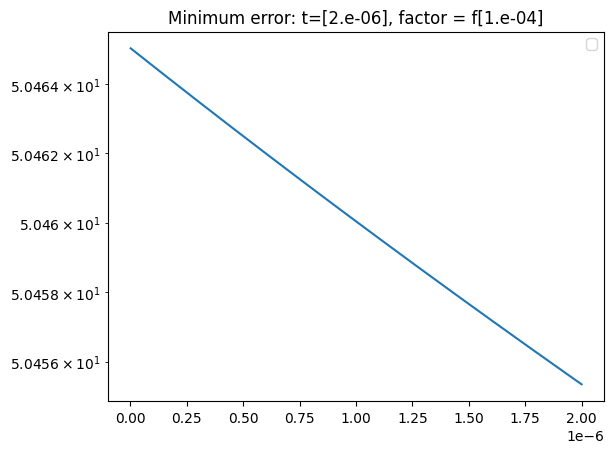

In [ ]:
dt = 0.000000001
t = 0

Nsteps = 2000

eps = (b-a)/50
mu = (b+a)/2
f0 = lambda x: nicekernel(x,mu,eps)
X = griglia.globV
u = f0(X)
ts = []
fig, ax = plt.subplots()
# ax.plot(X,u/X,label="initial")
t_exact = t+dt*Nsteps/10000
grigliaconv = GRID((b+a)/2-2*eps,(b+a)/2+2*eps,10)
Y = discexact(X,t_exact,f0,grigliaconv,approx=True)

errs = np.array([])
for i in tqdm(range(Nsteps)):
    t+=dt
    ts = np.append(ts,t)
    u = advance(u,dt,griglia.M,A)
    err = np.sqrt(np.sum((u-Y)**2))
    errs = np.append(errs,err)

t_star = ts[errs==np.min(errs)]
factor = t_exact/t_star
ax.plot(ts,errs)
ax.set_yscale("log")
ax.set_title(f"Minimum error: t={t_star}, factor = f{factor}")
ax.legend()
plt.show()

100%|██████████| 859/859 [00:01<00:00, 495.97it/s]


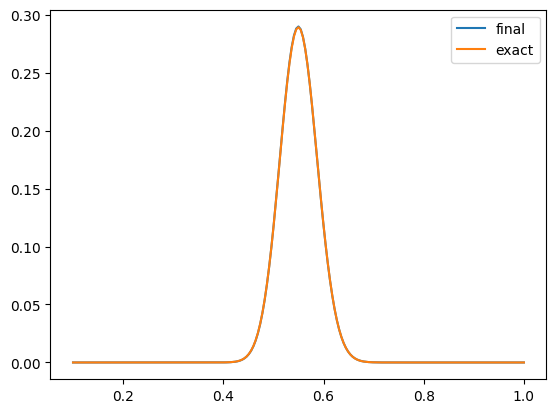

In [ ]:
dt = 0.000001
t = 0

Nsteps = 859

eps = (b-a)/50
mu = (b+a)/2
f0 = lambda x: nicekernel(x,mu,eps)
X = griglia.globV
u = f0(X)
ts = []
fig, ax = plt.subplots()
# ax.plot(X,u/X,label="initial")

errs = np.array([])
for i in tqdm(range(Nsteps)):
    t+=dt
    ts = np.append(ts,t)
    u = advance(u,dt,griglia.M,A)
#     err = np.sqrt(np.sum((u-Y)**2))
#     errs = np.append(errs,err)

# tstar = ts[errs==np.min(errs)]
# print(tstar)
ax.plot(X,u,label="final")
# ax.plot(ts,errs)
# ax.set_yscale("log")
grigliaconv = GRID((b+a)/2-2*eps,(b+a)/2+2*eps,10)
Y = discexact(X,t*factor,f0,grigliaconv,approx=True)
sigma = Y
ax.plot(X,sigma,label="exact")
ax.legend()

plt.show()

### Test di convergenza (spaziale)

In [ ]:
rmin = 1e-1 #raggio minimo
alpha = 1/2 # nu = Ar^alpha
a, b = rmin, 1

dt = 2**(-3)*1e-6
T = 2**12*1e-6
Nsteps = int(T/dt)

figfolder = "graphics/unmezzo_spaziale"
Path(figfolder).mkdir(parents=True,exist_ok=True)

Ns = 2*np.logspace(1,2,10).astype(int)
hs = (b-a)/Ns

eps = (b-a)/50
mu = (b+a)/2
f0 = lambda x: nicekernel(x,mu,eps)

grigliaconv = GRID((b+a)/2-2*eps,(b+a)/2+2*eps,10)

ndofs = np.arange(2,3)
fe = FE(ndof)

errs_ndofs = []
counter = 0

for ndof in ndofs:
    fe = FE(ndof)
    errs = []

    for j, N in enumerate(Ns):
        griglia = GRID(a,b,N,ndof=ndof,getM=True,fe=fe)
        A = getA(fe,griglia,adisc,constantdiffusion=False)

        t = 0

        X = griglia.globV
        u = f0(X)
        ts = []
        fig, ax = plt.subplots()
        ax.plot(X,u,label="initial")
        for i in range(Nsteps):
            t+=dt
            ts = np.append(ts,t)
            u = advance(u,dt,griglia.M,A)

        Y = discexact(X,t*factor,f0,grigliaconv,approx=True)
        err = np.sqrt(np.sum((u-Y)**2))
        errs.append(err)
        ax.plot(X,u,label="final")
        ax.plot(X,Y,label="exact final")
        ax.set_title(f"ndof={ndof}, N={N}")
        ax.legend()
        ax.grid()
        filename = f"{figfolder}/{counter:03d}.png"
        fig.savefig(filename)
        plt.close()
        counter += 1

    errs = np.array(errs)
    errs_ndofs.append(errs)

with open("h.pkl","wb") as f:
    pickle.dump(errs,f)

100%|██████████| 200/200 [00:47<00:00,  4.19it/s]


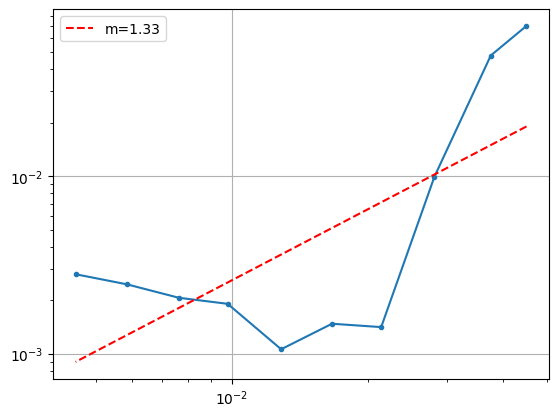

In [ ]:
with open("h.pkl","rb") as f:
    errs = pickle.load(f)

fig, ax = plt.subplots()

for errs in errs_ndofs:
    Xfit = np.log10(hs)
    Yfit = np.log10(errs)
    popt, _ = curve_fit(line,Xfit,Yfit)
    ax.plot(hs,errs,'.-')
    ax.plot(hs,10**line(Xfit,*popt),'--r',label=f"m={popt[0]:0.2f}")
ax.set_xscale("log")
ax.set_yscale("log")
ax.grid()
ax.legend()
plt.show()